In [1]:
import os
import keras
from keras.applications.inception_v3 import preprocess_input# import inception_v3 as inc_net
from keras.preprocessing import image
from keras.models import load_model
from skimage.io import imread
#from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

print('Notebook run using keras:', keras.__version__)

Using TensorFlow backend.


Notebook run using keras: 2.1.6


In [2]:
img_size = 299

def getHighestID(preds):
    id = -1
    max = -1
    for i in range(len(preds[0])):
        if preds[0][i]>max:
            max = preds[0][i]
            id=i
    return id

def getLabels():
    with open('labels.txt', 'r') as f:
     myLabels = [line.strip() for line in f]
    return myLabels

def getLabelFromID(id):
    with open("labels.txt") as fp:
        for i, line in enumerate(fp):
            if i == id:
                return line
    raise Exception('ID is not in file')
    
def decode_prediction(preds):
    label_list = getLabels()    
    decoded_list = list()
    decoded_list.append([])
    for i in range(len(label_list)):
        decoded_list[0].append([label_list[i],preds[0][i]])
    return decoded_list

def getIDFromLabel(label):
    with open("labels.txt") as fp:
        for i, line in enumerate(fp):
            if label == line.replace('\n',''):
                return i
    raise Exception('Label is not in file') 

In [3]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(img_size, img_size))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        out.append(x)
    return np.vstack(out)

In [4]:
my_model = load_model('my_model299.h5')
print('Model loaded')
images = transform_img_fn([os.path.join('data','daisy.jpg')])
preds = my_model.predict(images)

Model loaded


['daisy', 0.99968207]
['dandelion', 2.6278132e-05]
['roses', 1.9043233e-05]
['sunflowers', 0.00024211401]
['tulips', 3.0457712e-05]


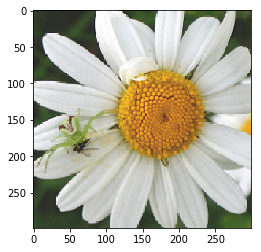

In [5]:
plt.imshow(images[0]/2 +0.5)

preds = sorted(preds, key=lambda x: x[1], reverse=True)
for x in decode_prediction(preds)[0]:
    print(x)

In [6]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [7]:
explainer = lime_image.LimeImageExplainer()

In [8]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0], my_model.predict, top_labels=5, hide_color=None, num_samples=1000)

CPU times: user 12.1 s, sys: 1.31 s, total: 13.4 s
Wall time: 12.9 s


daisy



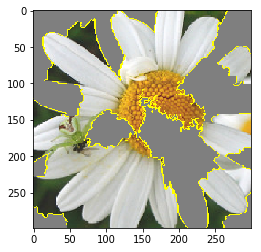

In [12]:
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(getHighestID(preds), positive_only=True, num_features=3000, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print(getLabelFromID(getHighestID(preds)))
